# ABS Inflation multi-measure

## Python set-up

In [1]:
# system imports
from io import StringIO

# analytic imports
import pandas as pd
import sdmxabs as sa
import mgplot as mg

In [2]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# save charts in this notebook
CHART_DIR = "./CHARTS/Inflation-sdmx/"
mg.set_chart_dir(CHART_DIR)
mg.clear_chart_dir()

# display charts in this notebook
SHOW = False

## Exploratory data analysis

In [10]:
df = sa.data_flows()
df[df.name.str.contains("National Accounts")].sort_values("name").head(10)

,agencyID,version,isFinal,name
dataflows,,,,
ANA_EXP,ABS,1.0.0,true,Australian National Accounts - Expenditure on Gross Domestic Product (GDP (E))
ANA_SFD,ABS,1.0.0,true,Australian National Accounts - State Final Demand
ANA_AGG,ABS,1.0.0,true,Australian National Accounts Key Aggregates
ANA_INC,ABS,1.0.0,true,Australian National Accounts – Income from Gross Domestic Product (GDP (I))
ANA_IND_GVA,ABS,1.0.0,true,Australian National Accounts – Production of Gross Domestic Product (GDP (P))


In [11]:
sa.data_dimensions("ANA_EXP")

,position,id,version,agencyID,package,class
dimensions,,,,,,
MEASURE,1,CL_ANA_MEASURE,1.0.0,ABS,codelist,Codelist
DATA_ITEM,2,CL_ANA_EXP_ITEMS,0.0.3,ABS,codelist,Codelist
SECTOR,3,CL_ANA_SECTOR,1.0.0,ABS,codelist,Codelist
TSEST,4,CL_TSEST,1.0.0,ABS,codelist,Codelist
REGION,5,CL_STATE,1.0.0,ABS,codelist,Codelist
FREQ,6,CL_FREQ,1.0.0,ABS,codelist,Codelist


In [20]:
sa.code_lists("CL_ANA_EXP_ITEMS")

,name
CL_ANA_EXP_ITEMS,
DFD,Domestic final demand
FCE,Final consumption expenditure
FCE_DEF,Final consumption expenditure - Defence
FCE_NDEF,Final consumption expenditure - Non-defence
GFC,Gross fixed capital formation
GFC_AAD,Gross fixed capital formation - Dwellings - Alterations and additions
GFC_ART,Gross fixed capital formation - Intellectual property products - Artistic originals
GFC_CBR,Gross fixed capital formation - Cultivated biological resources
GFC_CSW,Gross fixed capital formation - Intellectual property products - Computer software


## Download selected ABS series

In [48]:
text = """
flow_id, MEASURE, INDEX, TSEST, REGION, DATA_ITEM
CPI_M,         3, 10001,    10,     50, -
CPI_M,         3, 999905,   10,     50, -
CPI,           3, 10001,    10,     50, -
CPI,           3, 999902,   20,     50, -
CPI,           3, 999903,   20,     50, -
ANA_EXP,     DCH,      -,   20,     50, FCE
"""
selection = pd.read_csv(StringIO(text), dtype=str, skipinitialspace=True).set_index("flow_id")
pot = {}
for flow_id, row in selection.iterrows():
    data, meta = sa.fetch(flow_id, dims=row.to_dict(), validate=False)
    
    if "INDEX" in meta.columns:
        # --- General case for most data flows
        data_series = data[data.columns[0]].astype(float)
        meta_series = meta.iloc[0]
        name = f"{meta_series['FREQ']} {meta_series['INDEX']} ({meta_series['TSEST']})"
    else:
        # --- Household Final Consumption Expenditure is a sepecial case
        meta_series = meta.loc[meta.SECTOR == "Households"].squeeze()
        data_series = data[meta_series.name].astype(float).pct_change(4) * 100  # convert to percentage change
        name = f"{meta_series['FREQ']} {meta_series['SECTOR']} {meta_series['DATA_ITEM']} ({meta_series['TSEST']})"
    print(name)
    if meta_series['FREQ'] == "Quarterly":
        index = data_series.index.to_timestamp(how='end').to_period('M')
        data_series.index = index
        recent = data_series.index[-9]
    pot[name] = data_series.rename(name)


Monthly All groups CPI (Original)
Monthly Annual trimmed mean (Original)
Quarterly All groups CPI (Original)
Quarterly Trimmed Mean (Seasonally Adjusted)
Quarterly Weighted Median (Seasonally Adjusted)
Quarterly Households Final consumption expenditure (Seasonally Adjusted)


## Plot the data

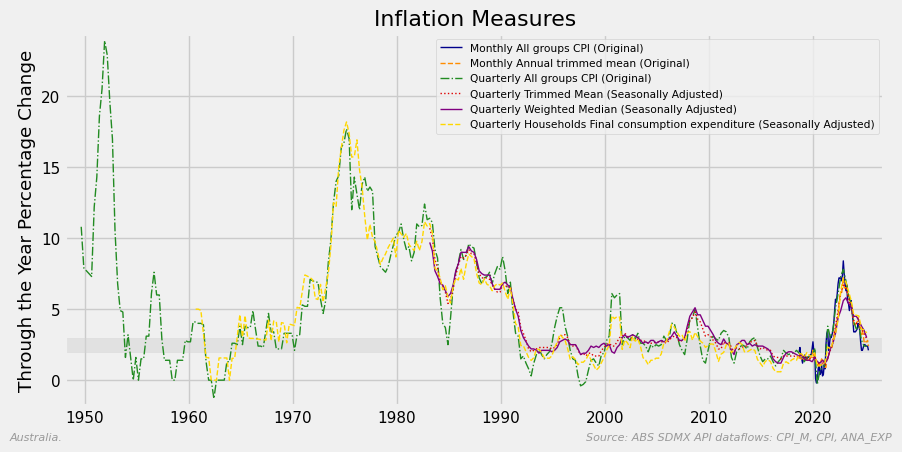

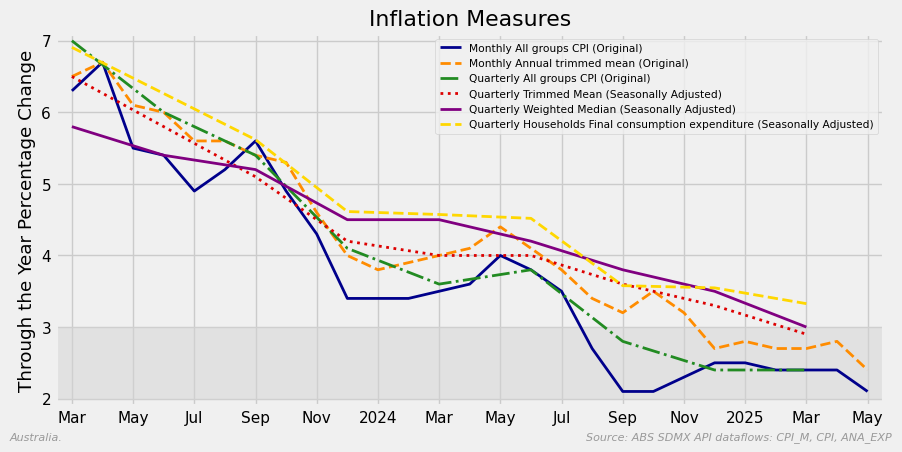

In [49]:
frame = pd.DataFrame(pot)
mg.multi_start(
    frame,
    starts=(0, recent),
    function=mg.line_plot_finalise,
    title="Inflation Measures",
    ylabel="Through the Year Percentage Change",
    axhspan={"ymin": 2, "ymax": 3, "color": "lightgrey", "alpha": 0.5, "label": "RBA Target Band"},
    show=True,
    legend=True,
    lfooter="Australia. ",
    rfooter=f"Source: ABS SDMX API dataflows: {', '.join(selection.index.unique())}"
)

## Finished

In [ ]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

In [ ]:
print("Finished")